In [22]:
import os
import requests
from bs4 import BeautifulSoup
import json
from lxml import etree
import logging
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

2024-10-17 15:10:23,684 - INFO - NumExpr defaulting to 8 threads.


## Come installare la cartella con tutti i documenti

1.   Vai su Google Drive.
2.   Trova la cartella condivisa "progettoIngDati".
3.   Fai clic con il pulsante destro del mouse sulla cartella e   
     seleziona :
     - Organizza.
     - Aggiungi Scorciatoia
     - Tutte le posizioni
4.   Scegli "My Drive" come destinazione per il collegamento.

In [2]:
#in questo modo caricate il vostro drive, che peró noi non vedremo!
#ma prima é importante che eseguiate le istruzioni qui sopra!
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
SOURCES_DIR = 'sources/'
EXTRACTION_DIR = 'extraction/'

if not os.path.exists(SOURCES_DIR):
    os.makedirs(f'./{SOURCES_DIR}', exist_ok=True)

if not os.path.exists(EXTRACTION_DIR):
    os.makedirs(f'./{EXTRACTION_DIR}', exist_ok=True)

Cancella la cartella articoli/ (se  serve)

In [11]:
!rm -rf sources/

# DOI Scouting (article id) and HTML Download
Questa sezione esegue una query su arxiv.org cercando articoli che parlano di **LLM multi agent** e attraverso *bs4* ottiene i vari [DOI](https://en.wikipedia.org/wiki/Digital_object_identifier).
Con questi DOI è dunque possibile eseguire richieste specifiche per scaricare i documenti HTML del topic scelto.  

In [6]:
article_ids = set()
TOPIC = "LLM multi agent"
found_urls = set()

Scarica il file HTML5 da ar5iv

In [13]:
def get_ar5iv_html(article_id):
    urls = [ f"https://ar5iv.labs.arxiv.org/html/{article_id}",
             f"https://arxiv.org/html/{article_id}" ]               # sometimes html is provided on this url when it's not showing on ar5ive
    for url in urls:
        try:
            response = requests.get(url, timeout=10)
            logging.info(f"Request URL: {response.url}")

            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')

                # Trova il tag <article> o altri contenuti rilevanti
                article = soup.find('article')

                if article:
                    found_urls.add(url)
                    return article

                # Se non troviamo un tag <article>, proviamo con <div> o <section>
                # if not article:
                #     article = soup.find('div', {'class': 'ltx_page'})  # Prova a trovare un'altra sezione

            else:
                logging.error(f"Error fetching article {article_id}, status code: {response.status_code}")
                return None

        except requests.exceptions.RequestException as e:
            logging.error(f"Error downloading article {article_id}: {e}")
            return None
    with open('/content/drive/MyDrive/progettoIngDati/read.me', 'w') as f:
        f.writelines([url + '\n' for url in found_urls])
        logging.info(f"Successfully wrote {len(found_urls)} urls to read.me")

Salva l'articolo in un file


In [14]:
def save_to_file(article, article_id):
    # Crea una cartella per gli articoli se non esiste
    #os.makedirs("articoli", exist_ok=True)
    #file_path = os.path.join("articoli", f"ar5iv_article_{article_id}.html")
    #with open(file_path, "w", encoding="utf-8") as file:
    #    file.write(article.prettify())
    #se hai montato la cartella questo funziona, altrimenti usa la parte commentata qui sopra
    file_path = os.path.join(SOURCES_DIR, f"ar5iv_article_{article_id}.html") #join with articoli_path
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(article.prettify())
    logging.info(f"Articolo {article_id} salvato.")

Cerca articoli simili e prova a scaricarne il contenuto html

In [15]:
def retrieve_article_id(url, params):
    response = requests.get(url, params=params)
    logging.info(f"Request URL: {response.url}")

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")

        ol_tag = soup.find('ol')
        if ol_tag:
            li_tags = ol_tag.find_all('li')
            local_article_counter = 0

            for li in li_tags:
                a_tag = li.find('a')
                if a_tag:
                    article_id = a_tag.text.split(':')[-1]
                    logging.info(f"Processing article number: {len(article_ids)}: {article_id}")
                    article = get_ar5iv_html(article_id)
                    if article:
                        logging.info(f"Article found: {article_id}")
                        local_article_counter += 1
                        article_ids.add(article_id)
                        save_to_file(article, article_id)
                    else:
                        logging.warning(f"Article {article_id} not found, skipping...")
                else:
                    logging.warning("No <a> element found in the <li> element.")

            logging.info(f"Number of local articles found: {local_article_counter} over 200")  # inside a single page
            time.sleep(2)
            return local_article_counter
        else:
            logging.warning("No <ol> element found.")
            return None
    else:
        logging.error(f"Failed to retrieve data. Status code: {response.status_code}")
        return None

Punto di lancio del codice, la query è composta da `url + params`

In [ ]:
# Define the URL for the advanced search on arXiv
url = "https://arxiv.org/search/advanced"

# Define the search parameters
params = {
    "advanced": "",
    "terms-0-term": TOPIC,              # Search term
    "terms-0-operator": "AND",          # Operator
    "terms-0-field": "all",             # Search field (all)
    "classification-computer_science": "y",  # Limit to computer science
    "classification-physics_archives": "all",  # Include all physics archives
    "classification-include_cross_list": "include",  # Include cross-list
    "date-filter_by": "all_dates",      # Filter by date (all dates)
    "date-year": "",                    # No specific year
    "date-from_date": "",               # No start date
    "date-to_date": "",                 # No end date
    "date-date_type": "submitted_date", # Search by submission date
    "abstracts": "hide",                # Show abstracts
    "size": 200,                        # Number of results to display
    "order": "submitted_date"           # Order by submission date (oldest first) #older documents are more likely to have html version
}

doi_retrieved = 0
while doi_retrieved <= 300:
    doi_retrieved += retrieve_article_id(url, params)
    params["start"] = doi_retrieved

logging.info(f"Number of articles retrieved: {len(article_ids)}")

# Data Extraction

In [5]:
def estrai_dati_da_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    parser = etree.HTMLParser()
    tree = etree.fromstring(content, parser)

    tabelle = {}
    table_counter = 0

    figure_with_tables = tree.xpath('//figure[.//table]')

    for figure in figure_with_tables:
        try:
            try:
                table_id = figure.xpath("@id")[0]
            except:
                # cerca l'id al secondo div padre perché a volte è salvato lì
                table_id = figure.xpath('ancestor::div[2]/@id')[0]
            table = figure.xpath('.//table')[0]
            table_counter += 1
            table_key = f"id_table_{table_counter}"

            caption = figure.xpath('.//figcaption//text()')
            caption_text = '' 

            if caption:
                caption_text = ''.join([c.strip() for c in caption]).replace('  ', ' ')

            dati_tabella = []
            rows = table.xpath('.//tr[position()>1]')
            for row in rows:
                cols = row.xpath('.//td')
                dati_row = [etree.tostring(col, encoding='unicode', method='html') for col in cols]
                dati_tabella.append(dati_row)

            references = tree.xpath(f"//p[a/@href = '#{table_id}']")
            references_text = [ref.xpath('string(.)').replace('\n', '').strip() for ref in references]   #elimina /n ma introduce spazi bianchi
            
            note_a_pie_di_pagina = []
            footnotes = figure.xpath(".//span[contains(@id, 'footnote') and contains(@class, 'ltx_text')]")
            for footnote in footnotes:
                logging.info(f"footnote found: {footnote} at table: {table_id}")

                footnote_text = " ".join(footnote.xpath(".//text()")).strip()
                if footnote_text and footnote_text != " ":
                    footnote_text = footnote_text.replace("\n", " ")
                    note_a_pie_di_pagina.append(footnote_text)

            tabelle[table_key] = {
                "caption": caption_text,
                "table": dati_tabella,
                "footnotes": note_a_pie_di_pagina,
                "references": references_text,
            }

        except Exception as e:
            logging.error(f"figure info: {figure.getchildren()}")
            logging.error(f"Error processing figure in {file_path}: {e.with_traceback()}")
            logging.error(f"Figure content: {etree.tostring(figure, encoding='unicode', pretty_print=True)}")
            break

    # for table_key, table_data in tabelle.items():
    #     logging.info(f"Footnotes for table {table_key}: {table_data['footnotes']}")
    return tabelle

In [6]:
# Funzione per salvare i dati estratti in un file JSON
def salva_dati_in_json(dati_estratti, article_id, extraction_path):
    tabelle = dati_estratti

    # Salva i dati in un file JSON
    output_file_path = f"{extraction_path}/{article_id}.json"
    os.makedirs(extraction_path, exist_ok=True)
    with open(output_file_path, 'w', encoding='utf-8') as json_file:
        json.dump(tabelle, json_file, ensure_ascii=False, indent=4)

    #logging.info(f"Dati salvati in {output_file_path}")

In [7]:
# per testare su di un unico file
file_path = os.path.join(SOURCES_DIR, 'ar5iv_article_2406.14952.html')

dati_estratti = estrai_dati_da_file(file_path)
logging.info(dati_estratti)
# Salva i dati in JSON
salva_dati_in_json(dati_estratti, '0', EXTRACTION_DIR)

2024-10-17 14:33:16,078 - INFO - {'id_table_1': {'caption': 'Table 1:Human judgementZH/ENresults of different role-playing agents.', 'table': [['<td class="ltx_td ltx_align_center ltx_border_r ltx_border_t" id="S2.T1.1.1.1.1">\n          GPT-4\n          <sub class="ltx_sub" id="S2.T1.1.1.1.1.1">\n           <span class="ltx_text ltx_font_italic" id="S2.T1.1.1.1.1.1.1">\n            zero_shot\n           </span>\n          </sub>\n         </td>\n         ', '<td class="ltx_td ltx_align_justify ltx_align_top ltx_border_t" id="S2.T1.1.1.1.2">\n          <span class="ltx_inline-block ltx_align_top" id="S2.T1.1.1.1.2.1">\n           <span class="ltx_p" id="S2.T1.1.1.1.2.1.1" style="width:35.6pt;">\n            9.9/\n            <span class="ltx_text ltx_font_bold" id="S2.T1.1.1.1.2.1.1.1">\n             9.8\n            </span>\n           </span>\n          </span>\n         </td>\n         ', '<td class="ltx_td ltx_align_justify ltx_align_top ltx_border_t" id="S2.T1.1.1.1.3">\n         

In [8]:
# Itera attraverso i file nella cartella 'articoli' e estrae le tabelle, didascalie, note e riferimenti
table_counter = 0
total_captions = 0
total_footnotes = 0
total_references = 0
articolo_counter = 0

table_ids = []
captions_count = []
footnotes_count = []
references_count = []

#questo é perché nel salvataggio dei file ho creato cartella articoli dentro a sources
for filename in os.listdir(SOURCES_DIR):
    file_path = os.path.join(SOURCES_DIR, filename)
    article_id = filename.split('_')[2].replace('.html', '')  # Estrae l'ID dal nome del file (primo elemento prima del punto)

    articolo_counter += 1  # Incrementa il contatore
    logging.info(f"Estraendo dati dall'articolo {articolo_counter}: {filename}...")

    # Estrai i dati dal file HTML
    dati_estratti = estrai_dati_da_file(file_path)

    # Update statistics counters
    for table_data in dati_estratti.values():
        table_counter += 1
        table_ids.append(f'Table {table_counter}')
        captions_count.append(1 if table_data["caption"] else 0)
        footnotes_count.append(len(table_data["footnotes"]))
        references_count.append(len(table_data["references"]))

        if table_data["caption"]:
            total_captions += 1
        total_footnotes += len(table_data["footnotes"])
        total_references += len(table_data["references"])

    # Salva i dati in JSON
    salva_dati_in_json(dati_estratti, article_id, EXTRACTION_DIR)
        
# Print statistics
logging.info("\n--- Extraction Statistics ---")
logging.info(f"Total Articles Processed: {articolo_counter}")
logging.info(f"Total Tables Found: {table_counter}")
logging.info(f"Total Captions Found: {total_captions}")
logging.info(f"Total Footnotes Found: {total_footnotes}")
logging.info(f"Total References Found: {total_references}")

2024-10-17 14:33:18,555 - INFO - Estraendo dati dall'articolo 1: ar5iv_article_2208.13266.html...
2024-10-17 14:33:19,084 - INFO - Estraendo dati dall'articolo 2: ar5iv_article_2302.01560.html...
2024-10-17 14:33:20,009 - INFO - Estraendo dati dall'articolo 3: ar5iv_article_2304.04370.html...
2024-10-17 14:33:20,173 - INFO - footnote found: <Element span at 0x21b17227f80> at table: A1.T1
2024-10-17 14:33:20,175 - INFO - footnote found: <Element span at 0x21b17227d00> at table: A1.T1
2024-10-17 14:33:20,179 - INFO - footnote found: <Element span at 0x21b17227e80> at table: A1.T1
2024-10-17 14:33:20,182 - INFO - footnote found: <Element span at 0x21b17227940> at table: A1.T1
2024-10-17 14:33:20,188 - INFO - footnote found: <Element span at 0x21b17227840> at table: A1.T1
2024-10-17 14:33:20,204 - INFO - footnote found: <Element span at 0x21b162058c0> at table: A1.T2
2024-10-17 14:33:20,207 - INFO - footnote found: <Element span at 0x21b162050c0> at table: A1.T2
2024-10-17 14:33:20,209 - I

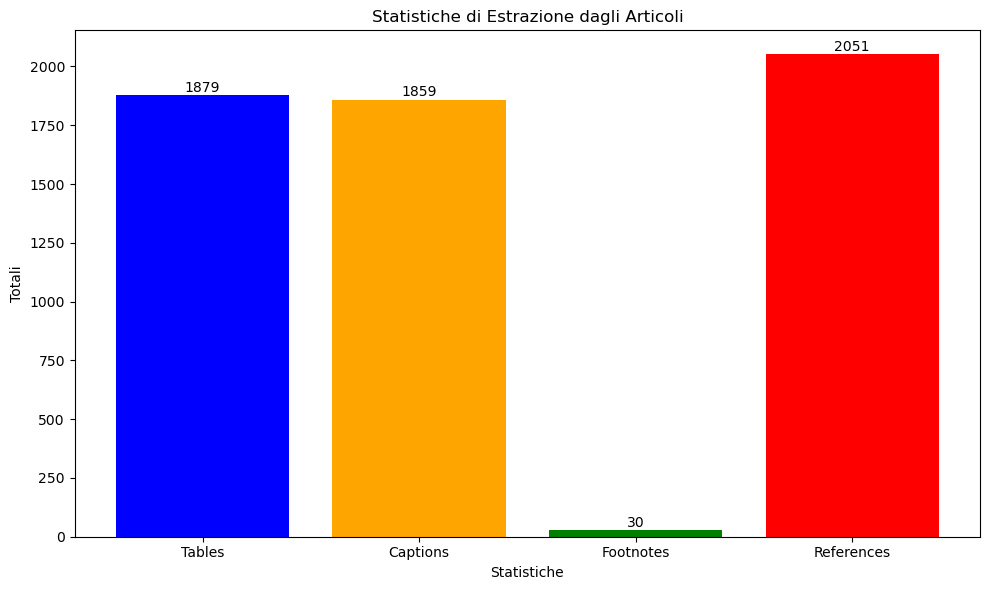

In [30]:
# Creazione dei grafici
labels = ['Tables', 'Captions', 'Footnotes', 'References']
values = [table_counter, total_captions, total_footnotes, total_references]

# Grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])

# Aggiungi etichette e titolo
plt.xlabel('Statistiche')
plt.ylabel('Totali')
plt.title('Statistiche di Estrazione dagli Articoli')

# Mostra i valori sopra le barre
for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Mostra il grafico
plt.tight_layout()

plt.savefig(os.path.join('extraction_statistics.png'))
plt.show()

# Se vuoi salvare il grafico come file PNG


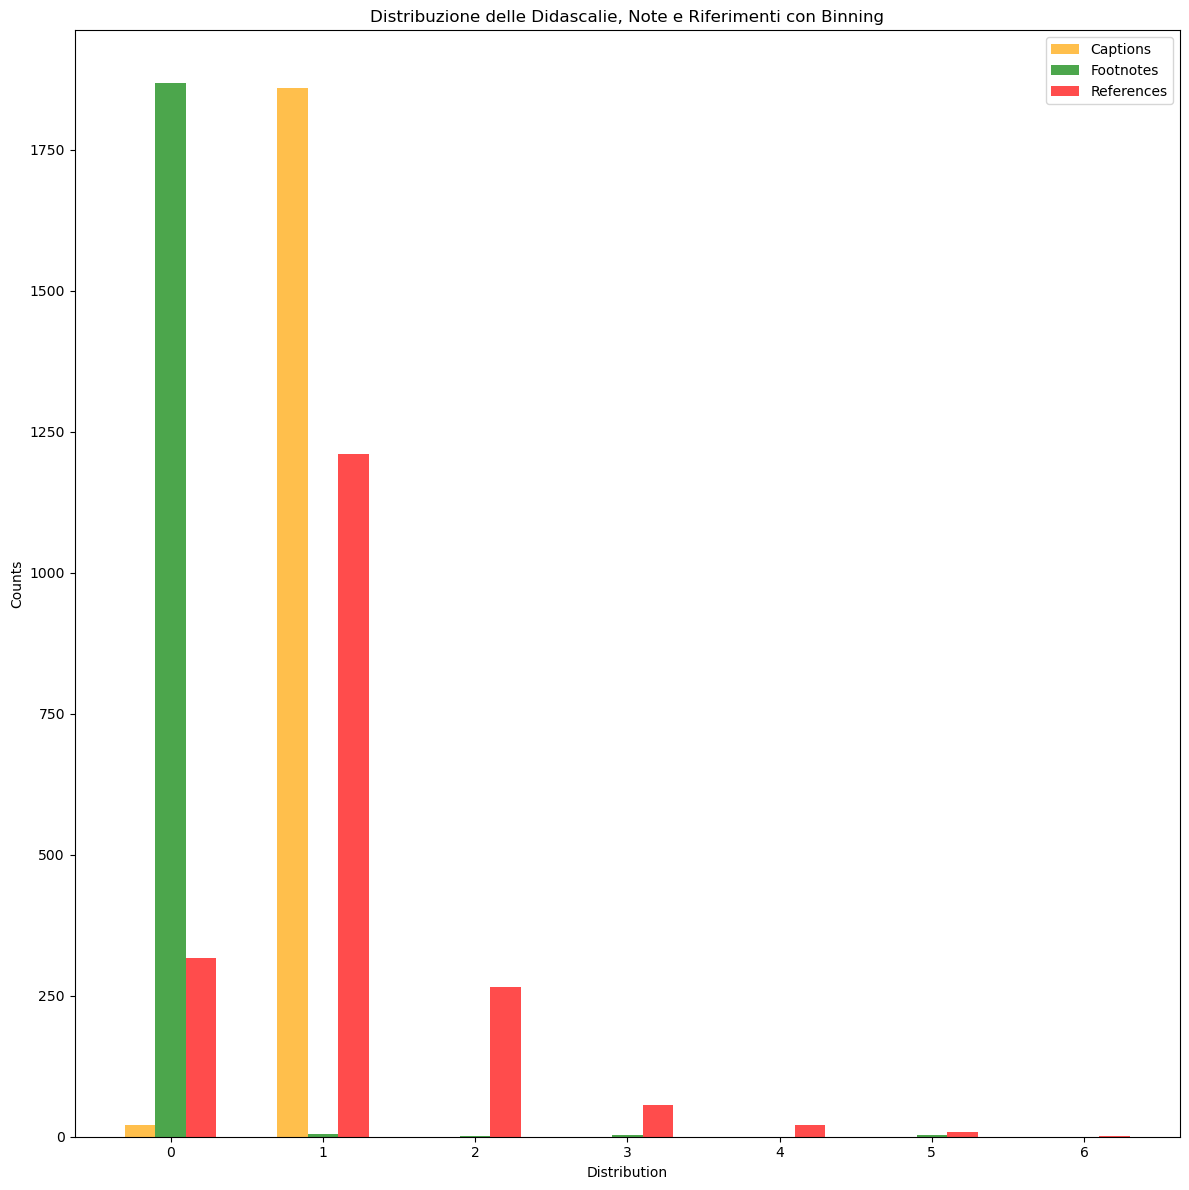

In [43]:
num_bins = 7

# Calcola il range per i bin
#bins = np.linspace(0, max(max(captions_count), max(footnotes_count), max(references_count)), num_bins + 1)
bins = np.linspace(0, 7, num_bins +1) 

# Calcolare gli istogrammi
captions_hist, _ = np.histogram(captions_count, bins=bins)
footnotes_hist, _ = np.histogram(footnotes_count, bins=bins)
references_hist, _ = np.histogram(references_count, bins=bins)

# Configurare le barre affiancate
bar_width = 0.2  # Larghezza delle barre
indices = np.arange(num_bins)

plt.figure(figsize=(12, 12))

# Crea l'istogramma
plt.bar(indices, captions_hist, width=bar_width, label='Captions', color= 'orange', alpha=0.7)
plt.bar(indices + bar_width, footnotes_hist, width=bar_width, label='Footnotes', color='green', alpha=0.7)
plt.bar(indices + 2 * bar_width, references_hist, width=bar_width, label='References', color='red', alpha=0.7)

# Aggiungi titoli e etichette
plt.xlabel('Distribution')
plt.ylabel('Counts')
plt.title('Distribuzione delle Didascalie, Note e Riferimenti con Binning')
plt.xticks(indices + bar_width,  range(num_bins))
plt.legend()

# Mostra l'istogramma
plt.tight_layout()
plt.savefig(os.path.join('extraction_distribution.png'))
plt.show()